In [43]:
from datetime import datetime
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host': 'elasticsearch', 'port': 9200}])

In [44]:
import time
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('⏰ {:s} function took {:.3f} ms'.format(f.__name__, (time2-time1)*1000.0))
        return ret
    return wrap

In [45]:
es.indices.get_alias("*")

{u'.apm-agent-configuration': {u'aliases': {}},
 u'.kibana_1': {u'aliases': {u'.kibana': {}}},
 u'.kibana_task_manager_1': {u'aliases': {u'.kibana_task_manager': {}}},
 u'montevideo': {u'aliases': {}}}

In [46]:
from elasticsearch.client import IndicesClient
ic = IndicesClient(es)

In [47]:
def analyzedText(text):
    results = ic.analyze(index="montevideo", body=
    {
      "text": text, 
        "analyzer":"calle_analyzer"
    })
    return ' '.join([token['token'] for token in results['tokens']])

In [317]:
def boosting_match_bool_search(text, size=500, boost=2, negative_boost=0.5, must_not="la el la las los calle psje 1 mas"):
    return es.search(index="montevideo", body=
{
    "from" : 0, "size" : size,
    "query": {
        "boosting" : {
            "positive" : {
                "bool" : {
                  "must" : {
                    "multi_match" : {
                        "query": text,
                        "analyzer": "calle_analyzer",
                        "fields": [ "nombre", "aliases" ],
                        "type": "best_fields"
                    
                    }
                  },
                  "must_not" : {
                    "multi_match" : {
                        "query": "la el la las los calle psje",
                        "analyzer": "calle_analyzer",
                        "fields": [ "nombre", "aliases" ],
                        "type": "best_fields"
                    }
                  },
                "boost" : boost
                }
            },
            "negative" : {
                "match" : {
                    "type" : "geonames_uy_montevideo v_mdg_espacios_libres"
                }
            },
            "negative_boost" : negative_boost
        }
    },
    "highlight": {
        "fields": {
            "nombre":{},
            "aliases":{}
        }
    }
})['hits']['hits']

In [78]:
def search_geo_vias(id, size=10):
    return es.search(index="montevideo", body=
    {
        "from" : 0, "size" : size,
        "query" : {
            "bool": {
                "must": {
                    "match" : {
                        "type" : "v_mdg_vias"
                    }
                },
                "filter": {
                    "geo_shape": {
                        "geometry": {
                            "indexed_shape": {
                                "index": "montevideo",
                                "id": id,
                                "path": "geometry"
                            }
                        }
                    }
                }
            }
        }
    })['hits']['hits']

In [79]:
def stripName(name):
    return name.replace(' ','-').strip().lower()

In [80]:
def getMatchName(result_obj_1,result_obj_2):
    return result_obj_1['s_name'] + '|' + result_obj_2['s_name']

In [81]:
def matchedName(match_dict,result_object):
    matched_key = next((key for key in match_dict.keys() if result_object['s_name'] in key), None)
    return matched_key!=None

In [309]:
import math
def getScore(res_obj,minus_highlights=[]):
    highlights = set(res_obj['highlights']) - set(minus_highlights)
    how_many_highlights = max(len(highlights),1)
    avg_highlights_lenght = max(sum([len(hg) for hg in highlights])/how_many_highlights,3)
    elastic_score = res_obj['score']
    return how_many_highlights * math.log(avg_highlights_lenght) * elastic_score

In [275]:
def getMatchObj(match_type, res_obj,geo_obj=None):
    #I'm weighting how many terms matched (highlights) on each obj, maybe this should be optional because i'm changing elastic bias.
    if geo_obj: 
        common_highlights = set(res_obj['highlights']).intersection(geo_obj['highlights'])
        return {'score':getScore(res_obj)*getScore(geo_obj,common_highlights), 'objects':[res_obj,geo_obj], 'type':match_type}
    else:
        return {'score':getScore(res_obj), 'objects':[res_obj], 'type':match_type} 

In [84]:
from difflib import SequenceMatcher
def commonSignificantSubstringExists(text1,text2,limit=5):
    match = SequenceMatcher(None, text1, text2).find_longest_match(0, len(text1), 0, len(text2))
    #print(text1[match.a: match.a + match.size])  # -> apple pie
    #print(text2[match.b: match.b + match.size])  # -> apple pie
    return match.size > limit

In [98]:
def sameHighlights(obj1,obj2):
    intersection = set(obj1['highlights']).intersection(obj2['highlights'])
    return len(list(intersection))==len(obj1['highlights']) or len(list(intersection))==len(obj2['highlights'])

In [86]:
def tryToMatchLines(match_dict,line_results,all_results,favorMoreMatches=False):
    results = []
    if not favorMoreMatches:
        results = line_results.values()
    else:
        results = sorted(line_results.values(), key = lambda i: len(i['highlights']), reverse=True)
    for res_obj in results:
        if matchedName(match_dict, res_obj):
            #If there is alredy a match that involves this name continue
            continue
        for geo_result in search_geo_vias(res_obj['id']):
            #I only care for those objects intersecting current object AND where part of the original results.
            geo_obj = all_results.get(geo_result['_id'], None)
            if geo_obj and res_obj['s_name'] != geo_obj['s_name'] and not sameHighlights(res_obj,geo_obj) and not commonSignificantSubstringExists(res_obj['s_name'],geo_obj['s_name']):
                #I only need to care for different objects, matching names and not ids.
                #In case of streets more than one block can intersect with the next one, same name diff id.
                #I discard obj with same highlights or common significant substrings
                match_name = getMatchName(res_obj,geo_obj)
                match_obj = getMatchObj('LINES',res_obj,geo_obj)
                match_dict[match_name] = match_obj 

In [87]:
def tryToMatchPoints(match_dict,point_results,all_results):
    for key, res_obj in point_results.items():
        if matchedName(match_dict, res_obj):
            #If there is alredy a match that involves this name continue
            continue
        match_obj = getMatchObj('POINT',res_obj)
        match_dict[res_obj['s_name']] = match_obj

In [88]:
def tryToMatchPolygons(match_dict,polygon_results,all_results):
    for key, res_obj in polygon_results.items():
        if matchedName(match_dict, res_obj):
            #If there is alredy a match that involves this name continue
            continue
        match_obj = getMatchObj('POLYGON',res_obj)
        match_dict[res_obj['s_name']] = match_obj

In [228]:
def getResultObject(result):
    result_geo_type = result['_source']['geometry']['type']
    result_id = result['_id']
    result_score = result['_score']
    result_geometry = result['_source']['geometry']
    result_name = 'NO_NAME'
    if result['_source'].get('nombre', None):
            result_name = result['_source']['nombre'].encode('ascii', 'ignore').decode('ascii')
    elif result['_source'].get('aliases',None):
            result_name = result['_source']['aliases'].encode('ascii', 'ignore').decode('ascii')
    result_striped_name = stripName(result_name)
    result_highlights = []
    highlights = result.get('highlight',None)
    if highlights:
        for a in highlights.values():
            for b in a:
                for c in b.split(' '):
                    if '<em>' in c:
                        hg = c.replace('<em>','').replace('</em>','')
                        for hg_one in hg.split(','):
                            if not hg_one in result_highlights:
                                result_highlights.append(hg_one)
    return {'id':result_id,'geo_type':result_geo_type,'name':result_name, 's_name':result_striped_name,'score':result_score,'geometry':result_geometry, 'highlights':result_highlights}

In [294]:
def complete_search(text,searchResults=500,favorMoreMatches=False):  
    match_dict = {}
    
    line_results = {}
    point_results = {}
    polygon_results = {}
    all_results = {}

    boost=2
    negative_boost=0.6
    must_not="la el la las los calle psje 1 mas"
    
    results = boosting_match_bool_search(text,searchResults,boost,negative_boost, must_not)
    for result in results:
        result_object = getResultObject(result)
        #if len(result_object['highlights'])==0:
        #    print(text)
        #    print(result_object)
        #    print()
        if result_object['geo_type'] == 'LineString':
            line_results[result_object['id']] = result_object
        elif result_object['geo_type'] == 'Point':   
            point_results[result_object['id']] = result_object
        elif result_object['geo_type'] == 'Polygon':
            polygon_results[result_object['id']] = result_object
        else:
            print('Do i have other?')
        
    all_results.update(line_results)
    all_results.update(point_results)
    all_results.update(polygon_results)
    
    tryToMatchLines(match_dict,line_results,all_results,favorMoreMatches)
    tryToMatchPoints(match_dict,point_results,all_results)
    tryToMatchPolygons(match_dict,polygon_results,all_results)
    
    
    return results, sorted(match_dict.items(), key = lambda i: i[1]['score'], reverse=True)

In [340]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix as cm
def testKit(csv_file_name,line_score_limit=300, point_score_limit=100):
    test_set = pd.read_csv(csv_file_name,index_col=0)
    mejorMatch = []
    scoreMejorMatch = []
    matchType = []
    times = []
    for index, row in test_set.iterrows():
        time1 = time.time()
        results, matches = complete_search(row['texto'],500,True)
        time2 = time.time()
        times.append(float('{:.3f}'.format((time2-time1)*1000.0)))
        if any(matches):
            mejorMatch.append(matches[0][0])
            scoreMejorMatch.append(float(matches[0][1]['score']))
            matchType.append(matches[0][1]['type'])
        else:
            mejorMatch.append('')
            scoreMejorMatch.append(0)
            matchType.append('')
    test_set['mejorMatch'] = mejorMatch
    test_set['scoreMejorMatch'] = scoreMejorMatch
    test_set['matchType'] = matchType
    test_set['time_ms'] = times
    test_set['encontreUbicacionCalle'] = np.where((test_set['scoreMejorMatch'] > line_score_limit) & (test_set['matchType']=='LINES'), True, False)
    test_set['encontreUbicacion'] = np.where(test_set['encontreUbicacionCalle'] | ((test_set['scoreMejorMatch'] > point_score_limit) & ((test_set['matchType']=='POINT') | (test_set['matchType']=='POLYGON'))), True, False)
    tn, fp, fn, tp = cm(test_set['tieneUbicacion'],test_set['encontreUbicacion']).ravel()
    file_name = 'LINE_LIM:{}_POINT_LIM:{}_TN:{}_FP:{}_FN:{}_TP:{}-{}'.format(line_score_limit,point_score_limit,tn,fp,fn,tp,csv_file_name)
    test_set.to_csv(file_name)
    return test_set

In [341]:
test_set = testKit('test_complete.csv')

graficar los 4 valores de la MC para varios valores de limit

In [342]:
from sklearn.metrics import confusion_matrix as cm
cm(test_set['tieneUbicacion'],test_set['encontreUbicacion'])

array([[452,  33],
       [ 33,  69]])

In [343]:
from sklearn.metrics import confusion_matrix as cm
cm(test_set['tieneUbicacionCalle'],test_set['encontreUbicacionCalle'])

array([[499,  29],
       [  0,  59]])

In [344]:
test_set.describe()

,scoreMejorMatch,time_ms
count,587.000000,587.000000
mean,361.577488,188.392479
std,1511.068222,239.600801
min,0.000000,1.095000
25%,24.113365,22.705500
50%,39.608666,81.781000
75%,74.952737,259.681000
max,27475.291836,1249.437000


In [182]:
%matplotlib inline  


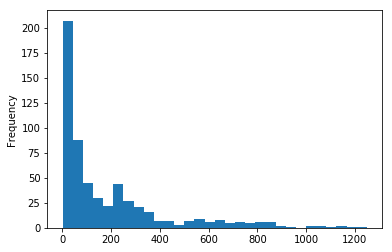

In [347]:
test_set.time_ms.plot.hist(bins=30)

In [348]:
test_set[
    (test_set['tieneUbicacion'] == True) & 
    (test_set['encontreUbicacion'] == False)
]

,tieneUbicacion,tieneUbicacionCalle,mejorMatch,scoreMejorMatch,texto,matchType,encontreUbicacionCalle,encontreUbicacion,time_ms
2,True,False,palacio-legislativo---edificio-anexo,78.285178,montevideo ahora choque esquina palacio legisl...,POINT,False,False,14.888
25,True,False,municipio-b,24.191990,charlas vecinos municipio calles irun esquina ...,POINT,False,False,15.482
32,True,False,montevideo-shopping,90.111854,cajero sacar plata ir feria esquina casa queda...,POINT,False,False,119.512
76,True,False,intendencia-municipal-de-montevideo,74.952737,Vergonzosa situación de la playa de Capurro se...,POINT,False,False,224.750
83,True,False,baha-de-montevideo,39.608666,Hicieron una ola de basura en el Montevideo sh...,POINT,False,False,30.743
85,True,False,dr-raul-rodriguez-barrios-plaza,38.345645,El mamarracho que la IM instaló en Plaza Zabal...,POLYGON,False,False,163.062
150,True,False,municipio-g,64.454174,Taller de Compost en el Municipio G. El comer ...,POINT,False,False,71.239
151,True,False,punta-gorda,66.167936,“Di Candia llevate esto al living de tu casa!!...,POINT,False,False,659.411
175,True,False,arroyo-del-miguelete,82.713639,El arroyo Miguelete de Montevideo está en muy ...,POINT,False,False,127.049
229,True,False,ciudad-de-pinerolo-plaza,38.900365,"Cada mes, la IM arroja al bolsillo de sus func...",POLYGON,False,False,141.712


In [144]:
test_set.to_csv('test_complete.csv')

In [290]:
text = test_set['texto'][472]
print(analyzedText(text))
results, matches = complete_search(text,500,True)
for match in matches[:4]:
    print ('✔️ MATCH: {}\t/\t{}'.format(match[1]['score'],match[0]))
print('\n')

montevideo ciudad mas insegura mas sucia mas empleados publicos mas planera mas subsidiada mas estatista centro adoctrinamiento marxista mas grande uruguay udelar sorprende votado zurdaje si aman vivir costa
✔️ MATCH: 642.450517502	/	arenal-grande|av-uruguay
✔️ MATCH: 43.3521390366	/	edificio-asociacion-de-empleados-bancarios-del-uruguay-(aebu)
✔️ MATCH: 39.608665645	/	baha-de-montevideo
✔️ MATCH: 39.608665645	/	puerto-de-montevideo




In [289]:
for res in boosting_match_bool_search(text,500):
    obj = getResultObject(res)
    print(obj['name'],obj['score'],obj['highlights'],obj['geo_type'])

(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'ASUNCION', 41.61135, [u'ASUNCION'], u'LineString')
(u'RICARDO PALMA', 18.626146, [u'PALMA'], u'LineString')
(u'RICARDO PALMA', 18.626146, [u'PALMA'], u'LineString')
(u'RICARDO PALMA', 18.626146, [u'PALMA'], u'LineString')
(u'RICARDO PALMA', 18.626146, [u'PALMA'], u'LineString')
(u'RICARDO PALMA', 18.626146, [u'PALMA'], u'LineString')
(u'PARAGUAY',